# DeepInsight for Gene-Expression

In [1]:
import os
import sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

from PIL import Image
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

#kerasでCNN構築
import time
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam


import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
path = "/Volumes/Buffalo-SSD/Kaggle_Datasets/gene-expression/"

In [3]:
os.listdir(path)

['._actual.csv',
 'actual.csv',
 'data_set_ALL_AML_independent.csv',
 '._data_set_ALL_AML_independent.csv',
 'data_set_ALL_AML_train.csv',
 '._data_set_ALL_AML_train.csv']

In [4]:
train = pd.read_csv(path+'data_set_ALL_AML_train.csv')
test = pd.read_csv(path+'data_set_ALL_AML_independent.csv')
actual = pd.read_csv(path+'actual.csv')

# 処理


In [5]:
def process1(df, actural, target):
    df1 = [col for col in df.columns if "call" not in col]
    df = df[df1]
    df = df.T
    df2 = df.drop(['Gene Description','Gene Accession Number'],axis=0)
    df2.index = pd.to_numeric(df2.index)
    df2.sort_index(inplace=True)
    if target == 'train':
        df2['cat'] = list(actual[:38]['cancer'])
    elif target == 'test':
        df2['cat'] = list(actual[38:]['cancer'])
    dic = {'ALL':0,'AML':1}
    df2.replace(dic,inplace=True)
    return df, df2

In [6]:
%time
train_df, train_df2 = process1(train, actual, 'train')
test_df, test_df2 = process1(test, actual, 'test')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


# 1st 次元削減

In [7]:
ALL_index = train_df2[train_df2['cat'] == 0].index - 1
AML_index = train_df2[train_df2['cat'] == 1].index - 1

In [8]:
y = train_df2['cat'].values
test_y = test_df2['cat'].values

train_df3 = train_df2.drop('cat', axis=1)
test_df3 = test_df2.drop('cat', axis=1)

sd = StandardScaler()
sd.fit(train_df3.T)
train_sd = sd.transform(train_df3.T)

# DeepInsight

# t-SNE

In [9]:
import DeepInsight

In [10]:
deepinsight = DeepInsight.DeepInsight()

In [13]:
%%time
train_images = deepinsight.fit_transform(train_df3, method='tsne')

CPU times: user 2min 28s, sys: 1min 19s, total: 3min 48s
Wall time: 3min 18s


In [14]:
%%time
test_images = deepinsight.transform(test_df3)

CPU times: user 1min 9s, sys: 1min 7s, total: 2min 16s
Wall time: 1min 48s


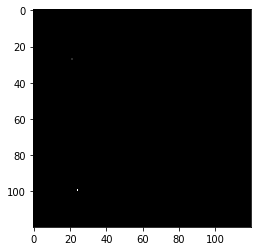

In [52]:
plt.imshow(train_images[11], cmap='gray')
plt.show()

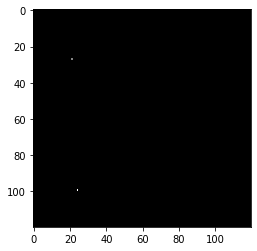

In [49]:
plt.imshow(test_images[1], cmap='gray')
plt.show()

In [53]:
train_images.shape

(38, 120, 120)

In [54]:
test_images.shape

(34, 120, 120)

In [15]:
train_images_flatten = train_images.reshape(38,-1)
test_images_flatten = test_images.reshape(34, -1)

In [16]:
train_images_flatten[:30].shape

(30, 14400)

## ランダムフォレスト

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

forest = RandomForestClassifier(criterion='gini', n_estimators=25, random_state=1, n_jobs=2) 
forest.fit(train_images_flatten, y)
accuracy_score(forest.predict(test_images_flatten), test_y)

0.5294117647058824

## CNN

In [18]:
X_train = train_images.reshape(38, 120, 120, 1)
X_test = test_images.reshape(34, 120 ,120, 1)

y_train = np_utils.to_categorical(y)
y_test = np_utils.to_categorical(test_y)

In [19]:
'''
CNNの構築
'''
 
model = Sequential()
 
model.add(Conv2D(filters=10, kernel_size=(3,3), padding='same', input_shape=(120, 120, 1), activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(filters=10, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(2, activation='softmax'))
 
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
 
'''
学習
'''
#計測開始
startTime = time.time()

# モデルの学習
early_stopping = EarlyStopping(patience=2, verbose=1)

history = model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=1,callbacks=[early_stopping], validation_data=(X_test, y_test))
 
score = model.evaluate(X_test, y_test, verbose=0)
 
print('Test Loss:{0:.3f}'.format(score[0]))
print('Test accuracy:{0:.3}'.format(score[1]))
#処理時間
print("time:{0:.3f}sec".format(time.time() - startTime))

Train on 38 samples, validate on 34 samples
Epoch 1/100
38/38 [==============================] - 2s 49ms/step - loss: 0.8312 - acc: 0.7105 - val_loss: 0.6932 - val_acc: 0.4118
Epoch 2/100
38/38 [==============================] - 0s 10ms/step - loss: 0.6930 - acc: 0.5000 - val_loss: 0.6929 - val_acc: 0.5882
Epoch 3/100
38/38 [==============================] - 0s 10ms/step - loss: 0.6922 - acc: 0.7105 - val_loss: 0.6924 - val_acc: 0.5882
Epoch 4/100
38/38 [==============================] - 0s 10ms/step - loss: 0.6911 - acc: 0.7105 - val_loss: 0.6919 - val_acc: 0.5882
Epoch 5/100
38/38 [==============================] - 0s 10ms/step - loss: 0.6897 - acc: 0.7105 - val_loss: 0.6913 - val_acc: 0.5882
Epoch 6/100
38/38 [==============================] - 0s 10ms/step - loss: 0.6884 - acc: 0.7105 - val_loss: 0.6908 - val_acc: 0.5882
Epoch 7/100
38/38 [==============================] - 0s 10ms/step - loss: 0.6867 - acc: 0.7105 - val_loss: 0.6903 - val_acc: 0.5882
Epoch 8/100
38/38 [=============

38/38 [==============================] - 0s 11ms/step - loss: 0.6344 - acc: 0.7105 - val_loss: 0.6775 - val_acc: 0.5882
Epoch 63/100
38/38 [==============================] - 0s 10ms/step - loss: 0.6338 - acc: 0.7105 - val_loss: 0.6775 - val_acc: 0.5882
Epoch 64/100
38/38 [==============================] - 0s 10ms/step - loss: 0.6332 - acc: 0.7105 - val_loss: 0.6775 - val_acc: 0.5882
Epoch 00064: early stopping
Test Loss:0.678
Test accuracy:0.588
time:28.004sec


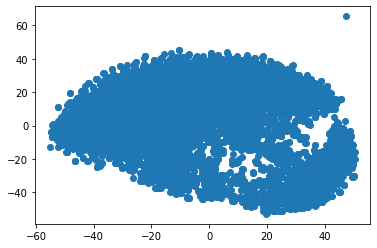

In [35]:
plt.scatter(deepinsight.result_points[:,0], deepinsight.result_points[:,1])
plt.show()

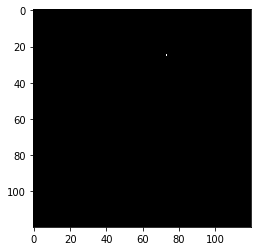

In [45]:
plt.imshow(train_images[0], cmap='gray')
plt.show()

# Kernel PCA

In [30]:
deepinsight2 = DeepInsight.DeepInsight()
kpca_train_images = deepinsight2.fit_transform(train_df3)
kpca_test_images = deepinsight2.transform(test_df3)

kpca_train_images_flatten = kpca_train_images.reshape(38,-1)
kpca_test_images_flatten = kpca_test_images.reshape(34, -1)

forest = RandomForestClassifier(criterion='gini', n_estimators=25, random_state=1, n_jobs=2) 
forest.fit(kpca_train_images_flatten, y)
accuracy_score(forest.predict(kpca_test_images_flatten), test_y)

0.7058823529411765

In [31]:
X_train = kpca_train_images.reshape(38, 120, 120, 1)
X_test = kpca_test_images.reshape(34, 120 ,120, 1)

y_train = np_utils.to_categorical(y)
y_test = np_utils.to_categorical(test_y)

In [32]:
'''
CNNの構築
'''
 
model = Sequential()
 
model.add(Conv2D(filters=10, kernel_size=(3,3), padding='same', input_shape=(120, 120, 1), activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(filters=10, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(2, activation='softmax'))
 
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
 
'''
学習
'''
#計測開始
startTime = time.time()

early_stopping = EarlyStopping(patience=2, verbose=1)

history = model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=2, callbacks=[early_stopping], validation_data=(X_test, y_test))
 
score = model.evaluate(X_test, y_test, verbose=0)
 
print('Test Loss:{0:.3f}'.format(score[0]))
print('Test accuracy:{0:.3}'.format(score[1]))
#処理時間
print("time:{0:.3f}sec".format(time.time() - startTime))

Train on 38 samples, validate on 34 samples
Epoch 1/100
 - 2s - loss: 0.6001 - acc: 0.7368 - val_loss: 0.7708 - val_acc: 0.5882
Epoch 2/100
 - 0s - loss: 0.6618 - acc: 0.7105 - val_loss: 0.7143 - val_acc: 0.5882
Epoch 3/100
 - 0s - loss: 0.6397 - acc: 0.7105 - val_loss: 0.6587 - val_acc: 0.5882
Epoch 4/100
 - 0s - loss: 0.5880 - acc: 0.7105 - val_loss: 0.6597 - val_acc: 0.5882
Epoch 5/100
 - 0s - loss: 0.5526 - acc: 0.7105 - val_loss: 0.6557 - val_acc: 0.5882
Epoch 6/100
 - 0s - loss: 0.5373 - acc: 0.7105 - val_loss: 0.6533 - val_acc: 0.5882
Epoch 7/100
 - 0s - loss: 0.5282 - acc: 0.7105 - val_loss: 0.6207 - val_acc: 0.5882
Epoch 8/100
 - 0s - loss: 0.4893 - acc: 0.7105 - val_loss: 0.5969 - val_acc: 0.5882
Epoch 9/100
 - 0s - loss: 0.4633 - acc: 0.7105 - val_loss: 0.5679 - val_acc: 0.5882
Epoch 10/100
 - 0s - loss: 0.4339 - acc: 0.7105 - val_loss: 0.5498 - val_acc: 0.5882
Epoch 11/100
 - 0s - loss: 0.4313 - acc: 0.7105 - val_loss: 0.5169 - val_acc: 0.5882
Epoch 12/100
 - 0s - loss: 0.4

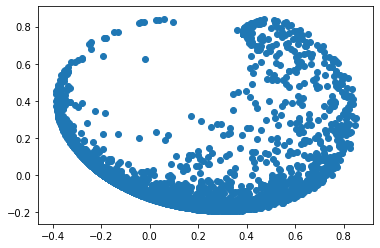

In [34]:
plt.scatter(deepinsight2.result_points[:,0], deepinsight2.result_points[:,1])
plt.show()

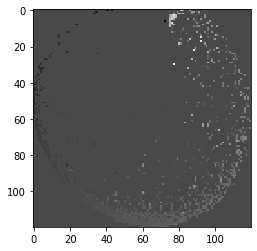

In [46]:
plt.imshow(kpca_train_images[0], cmap='gray')
plt.show()